 ## Prepare Data for Model Input

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [21]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb

In [3]:
df = pd.read_csv('salary_post_eda.csv')

In [4]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'sql_yn', 'tableau_yn', 'spark_yn', 'aws_yn', 'excel_yn', 'phd_yn',
       'masters_yn', 'bachelors_yn', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [5]:
# choose relevant columns
df_model = df[['avg_salary','Rating','Size','Type of ownership','Industry','Sector','Revenue','num_comp','hourly',
               'employer_provided','job_state','same_state','age','desc_len',
               'python_yn', 'R_yn','sql_yn', 'tableau_yn', 'spark_yn', 'aws_yn', 'excel_yn', 
               'phd_yn','masters_yn', 'bachelors_yn', 'job_simp', 'seniority']]

In [6]:
# get dummy data
df_dum = pd.get_dummies(df_model)

In [7]:
# train test split
X = df_dum.drop('avg_salary', axis = 1)
y = df_dum.avg_salary.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 88)

In [8]:
# multiple linear regression
X_sm = X = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

C:\Users\jamie\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     9.856
Date:                Tue, 25 Jan 2022   Prob (F-statistic):           7.48e-93
Time:                        10:40:55   Log-Likelihood:                -3307.5
No. Observations:                 742   AIC:                             6913.
Df Residuals:                     593   BIC:                             7600.
Df Model:                         148                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                43.2528      7.211      5.998      0.000      29.091      57.415
Rating                                                3.4606      1.959      1.766      0.078      -0.388       7.309
num_comp                                              2.1108      0.871      2.422      0.016       0.399       3.822
hourly                                              -37.3070      9.372     -3.981      0.000     -55.714     -18.900
employer_provided                                    31.9315     11.617      2.749      0.006       9.115      54.748
same_state                                            2.5599      2.630      0.973      0.331      -2.606       7.726
age                                                   0.0291      0.030      0.961      0.337      -0.030       0.089
desc_len                                             -0.0003      0.001     -0.322      0.747      -0.002       0.001
python_yn                                             9.3532      2.601      3.595      0.000       4.244      14.462
R_yn                                                 18.0532     29.110      0.620      0.535     -39.118      75.225
sql_yn                                               -2.0112      2.710     -0.742      0.458      -7.333       3.311
tableau_yn                                           -5.8602      3.110     -1.884      0.060     -11.969       0.248
spark_yn                                             -0.8827      2.997     -0.295      0.768      -6.768       5.003
aws_yn                                                1.2893      2.759      0.467      0.640      -4.129       6.708
excel_yn                                              0.1936      2.286      0.085      0.933      -4.296       4.683
phd_yn                                                1.9851      2.854      0.696      0.487      -3.620       7.590
masters_yn                                            0.3612      5.148      0.070      0.944      -9.750      10.472
bachelors_yn                                          1.4122      2.546      0.555      0.579      -3.588       6.412
Size_-1                                              12.6199      8.644      1.460      0.145      -4.357      29.597
Size_1 to 50 employees                                1.1936      6.546      0.182      0.855     -11.663      14.050
Size_10000+ employees                                -3.3593      5.812     -0.578      0.563     -14.773       8.054
Size_1001 to 5000 employees                           7.1075      3.961      1.794      0.073      -0.672      14.887
Size_201 to 500 employees                             3.0152      3.900      0.773      0.440      -4.644      10.674
Size_5001 to 10

Our R-squared of 0.711 is pretty high, meaning our predictor variables account for 71.1% of the variability in salary.  
  
We will take a significance level of 0.05, so we consider any variable with p-value less than 0.05 to be statistically significant.  
We can see that the number of competitors, whether a company pays hourly or not, whether the company requires certain skills (python, tableau), certain types of ownerships and industries, the job location and job title and seniority are important in determining a job's salary.

## Baseline Models

- Multiple Linear Regression:

In [9]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

np.mean(cross_val_score(model_lr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

-22.22147984455793

- Lasso Regression:

In [10]:
model_l = Lasso()
model_l.fit(X_train, y_train)
np.mean(cross_val_score(model_l, X_train, y_train, scoring = 'neg_mean_absolute_error',  cv = 3))

-22.508671729570384

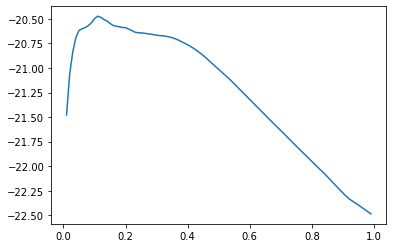

0.11

In [11]:
# let's find the best alpha to minimize error
alpha = []
error = []
for i in range(1,100):
    alpha.append(i/100)
    lasso = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lasso, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3)))
plt.plot(alpha, error)
plt.show()

alpha[np.argmax(error)]  # best alpha to minimize error

In [12]:
# lasso with optimized alpha
model_l = Lasso(alpha = alpha[np.argmax(error)])
model_l.fit(X_train, y_train)
np.mean(cross_val_score(model_l, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

-20.472964521515582

- Elastic Net Regression:

C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67006.86613951852, tolerance: 56.53323898734177
  positive)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:516: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\jamie\A

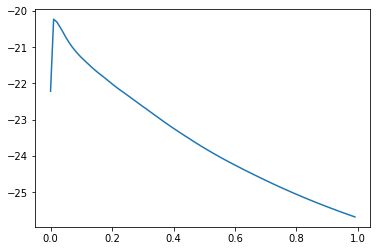

0.01


-20.239497915211242

In [13]:
# let's find the best alpha to minimize error
alpha = []
error = []
for i in range(0,100):
    alpha.append(i/100)
    en = ElasticNet(alpha=(i/100))
    error.append(np.mean(cross_val_score(en, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3)))
plt.plot(alpha, error)
plt.show()
print(alpha[np.argmax(error)])

# elastic net with optimized alpha
model_en = ElasticNet(alpha = alpha[np.argmax(error)])
model_en.fit(X_train, y_train)
np.mean(cross_val_score(model_en, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

- Kernel Ridge Regression:

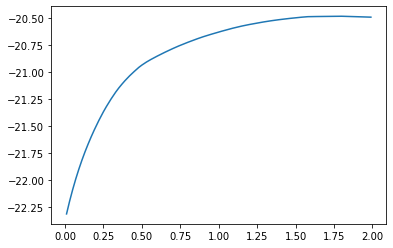

1.79


-20.484325516811253

In [14]:
# find the best alpha to minimize error
alpha = []
error = []
for i in range(1,200):
    alpha.append(i/100)
    kr = KernelRidge(alpha=(i/100))
    error.append(np.mean(cross_val_score(kr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3)))
plt.plot(alpha, error)
plt.show()
print(alpha[np.argmax(error)])

# kernel ridge with optimized alpha
model_kr = KernelRidge(alpha = alpha[np.argmax(error)])
model_kr.fit(X_train, y_train)
np.mean(cross_val_score(model_kr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

- Support Vector Regression:

In [15]:
model_svr = SVR()
model_svr.fit(X_train, y_train)
np.mean(cross_val_score(model_svr, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

-30.07541841537149

- Gradient Boosting Regression:

In [16]:
model_gb = GradientBoostingRegressor(learning_rate=0.05, n_estimators=2000, 
                                     loss='huber', random_state=88)
model_gb.fit(X_train, y_train)
np.mean(cross_val_score(model_gb, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

-13.741438733937715

- XGBoost Regression:

In [17]:
model_xgb = xgb.XGBRegressor(learning_rate=0.05, n_estimators=2000, random_state=88)
model_xgb.fit(X_train, y_train)
np.mean(cross_val_score(model_xgb, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

-13.081350470048067

- Random Forest:

In [18]:
model_rf = RandomForestRegressor(random_state=88)
model_rf.fit(X_train, y_train)
np.mean(cross_val_score(model_rf, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = 3))

C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


-16.166001811687092

In [26]:
# use RandomizedSearchCV to get an initial finetuned random forest model
param_grid = {'n_estimators': [10,50,100,150,200,250,400,350,400,450,500], 
              'bootstrap': [True,False],
              'criterion': ['mse','mae'],
              'max_depth': [3,5,10,None],
              'max_features': ['auto','sqrt','log2'],
              'min_samples_leaf': [1,2,5],
              'min_samples_split': [2,5,10]}

model_rf_rs = RandomizedSearchCV(model_rf, param_distributions = param_grid, scoring='neg_mean_absolute_error', cv=3, random_state=88)
model_rf_rs.fit(X_train,y_train)

print(model_rf_rs.best_score_)
print(model_rf_rs.best_estimator_)

C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-15.015278246205735
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=88, verbose=0,
                      warm_start=False)


In [30]:
# use GridSearchCV to finetune the parameters we obtained from the randomized search
param_grid = {'n_estimators': range(50,150,10), 
              'bootstrap': [False],
              'criterion': ['mse'],
              'max_depth': [1,2,3,None],
              'max_features': ['auto'],
              'min_samples_leaf': [1,2,5],
              'min_samples_split': [2,3,5]}

model_rf_gs = GridSearchCV(model_rf, param_grid, scoring='neg_mean_absolute_error', cv=3)
model_rf_gs.fit(X_train,y_train)

print(model_rf_gs.best_score_)
print(model_rf_gs.best_estimator_)

C:\Users\jamie\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-15.005354131534569
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=60,
                      n_jobs=None, oob_score=False, random_state=88, verbose=0,
                      warm_start=False)


#### Evaluate each model's score:

In [31]:
# get predictions of each model
tpred_lr = model_lr.predict(X_test)
tpred_l = model_l.predict(X_test)
tpred_en = model_en.predict(X_test)
tpred_kr = model_kr.predict(X_test)
tpred_svr = model_svr.predict(X_test)
tpred_gb = model_gb.predict(X_test)
tpred_xgb = model_xgb.predict(X_test)
tpred_rf = model_rf_gs.predict(X_test)

# get errors for each model
error_lr = mean_absolute_error(y_test,tpred_lr)
error_l = mean_absolute_error(y_test,tpred_l)
error_en = mean_absolute_error(y_test,tpred_en)
error_kr = mean_absolute_error(y_test,tpred_kr)
error_svr = mean_absolute_error(y_test,tpred_svr)
error_gb = mean_absolute_error(y_test,tpred_gb)
error_xgb = mean_absolute_error(y_test,tpred_xgb)
error_rf = mean_absolute_error(y_test,tpred_rf) 

# print out the errors
print('MAE for linear regression:', '{0:.4f}'.format(error_lr))
print('MAE for lasso:', '{0:.4f}'.format(error_l))
print('MAE for elastic net:', '{0:.4f}'.format(error_en))
print('MAE for kernel ridge:', '{0:.4f}'.format(error_kr))
print('MAE for support vector regression:', '{0:.4f}'.format(error_svr))
print('MAE for gradient boosting:', '{0:.4f}'.format(error_gb))
print('MAE for extreme gradient boosting:', '{0:.4f}'.format(error_xgb))
print('MAE for random forest:', '{0:.4f}'.format(error_rf))

MAE for linear regression: 18.7478
MAE for lasso: 18.6590
MAE for elastic net: 18.0456
MAE for kernel ridge: 18.1600
MAE for support vector regression: 28.9501
MAE for gradient boosting: 11.7536
MAE for extreme gradient boosting: 10.1892
MAE for random forest: 12.7030


From the list of mean absolute errors, we can notice that the best performing model is the XGB, with an MAE of $10.2K.  

## Mix Models  
We try to use a mixture of models to see if we can get a better estimator of salary, and get a model that is more robust to overfitting.  
  
Notice that SVR has a very high error, so I will not include that in the mixed model.  

In [32]:
# Get predictions from the mixed model
def tpred_mixed(X):
    return ((0.1 * model_lr.predict(X)) + 
            (0.1 * model_l.predict(X)) + 
            (0.1 * model_en.predict(X)) + 
            (0.1 * model_kr.predict(X)) + 
            (0.2 * model_gb.predict(X)) + 
            (0.2 * model_xgb.predict(X)) + 
            (0.2 * model_rf_gs.predict(X)))

error_mixed = mean_absolute_error(y_test, tpred_mixed(X_test))
print('MAE for mixed model:', '{0:.4f}'.format(error_mixed))

MAE for mixed model: 13.0736


Let's try a simpler mix with a smaller number of models.    
Out of lasso, elastic net and kernel ridge, elastic net has the lowest error, so I will not include the other two in the mixed model.  
Out of gradient boosting and XGB, XGB has the lower error.  

In [35]:
def tpred_mixed(X):
    return ((0.1 * model_lr.predict(X)) + 
            (0.2 * model_en.predict(X)) + 
            (0.4 * model_xgb.predict(X)) + 
            (0.3 * model_rf_gs.predict(X)))

error_mixed = mean_absolute_error(y_test, tpred_mixed(X_test))
print('MAE for mixed model:', '{0:.4f}'.format(error_mixed))

MAE for mixed model: 12.0255


So, in conclusion, the model that produced the lowest error for our test data was extreme gradient boosting with an average error of `$`10.2K.  
However, in the real world, I would use the simpler mixed model (mix of linear regression, elastic net, XGB, random forest) to predict salaries for jobs outside of our dataset. This mixed model has an average error of `$`12.0K and is more robust to overfitting than the XGB model.   